In [10]:
%%HTML
<style> code {background-color : pink !important;} </style>

Camera Calibration with OpenCV
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('calibration_wide/GO*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

In [4]:
print (corners.shape)

(48, 1, 2)


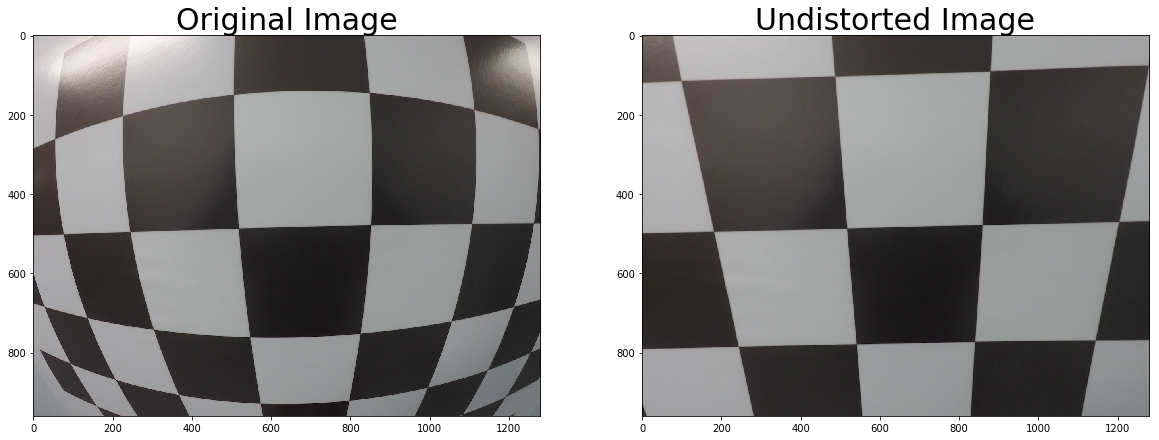

In [5]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('calibration_wide/test_image.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [8]:
print (mtx)
print (dist)

[[ 560.33148363    0.          651.26264911]
 [   0.          561.3767079   499.06540191]
 [   0.            0.            1.        ]]
[[ -2.32949182e-01   6.17242707e-02  -1.80423444e-05   3.39635746e-05
   -7.54961807e-03]]


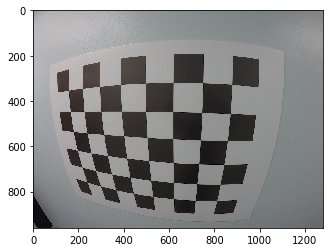

In [112]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "calibration_wide/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('calibration_wide/GOPR0047.jpg')
plt.imshow(img)


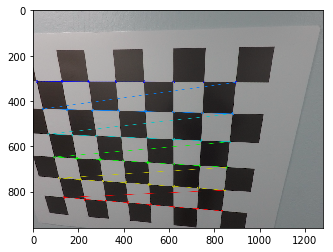

In [113]:
#gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
#plt.imshow(gray, cmap='gray')

img = cv2.undistort(img, mtx, dist, None, mtx)

# 2) Convert to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
#plt.imshow(gray)
# 3) Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
# 4) If corners found: 
        # a) draw corners
img = cv2.drawChessboardCorners(img, (8,6), corners, ret)
plt.imshow(img)

In [114]:
print (corners.shape)
print (corners[0], corners[1], corners[8], corners[9], corners[10])

(48, 1, 2)
[[  17.  315.]] [[ 127.58560181  313.8059082 ]] [[  43.16139221  434.83035278]] [[ 150.93644714  438.00274658]] [[ 262.57226562  440.65447998]]


In [115]:
#src = np.zeros((4, 1, 2), np.float32)
nx = 8
src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])

offset = 100
img_size = (gray.shape[1], gray.shape[0])

        # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
#dst = np.float32(
#    [[17, 315],
#     [127, 315],
#     [43, 434],
#     [153, 434]])
# d) use cv2.getPerspectiveTransform() to get M, the transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
# e) use cv2.warpPerspective() to warp your image to a top-down view
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

[[[  17.          315.        ]]

 [[ 894.66424561  317.64468384]]

 [[ 833.50549316  884.45269775]]

 [[ 137.71287537  825.33087158]]]


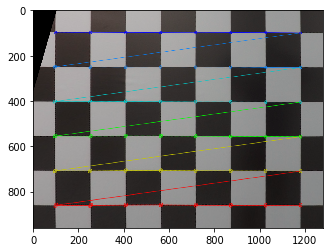

In [116]:
print (src)
plt.imshow(warped)
#print (src)

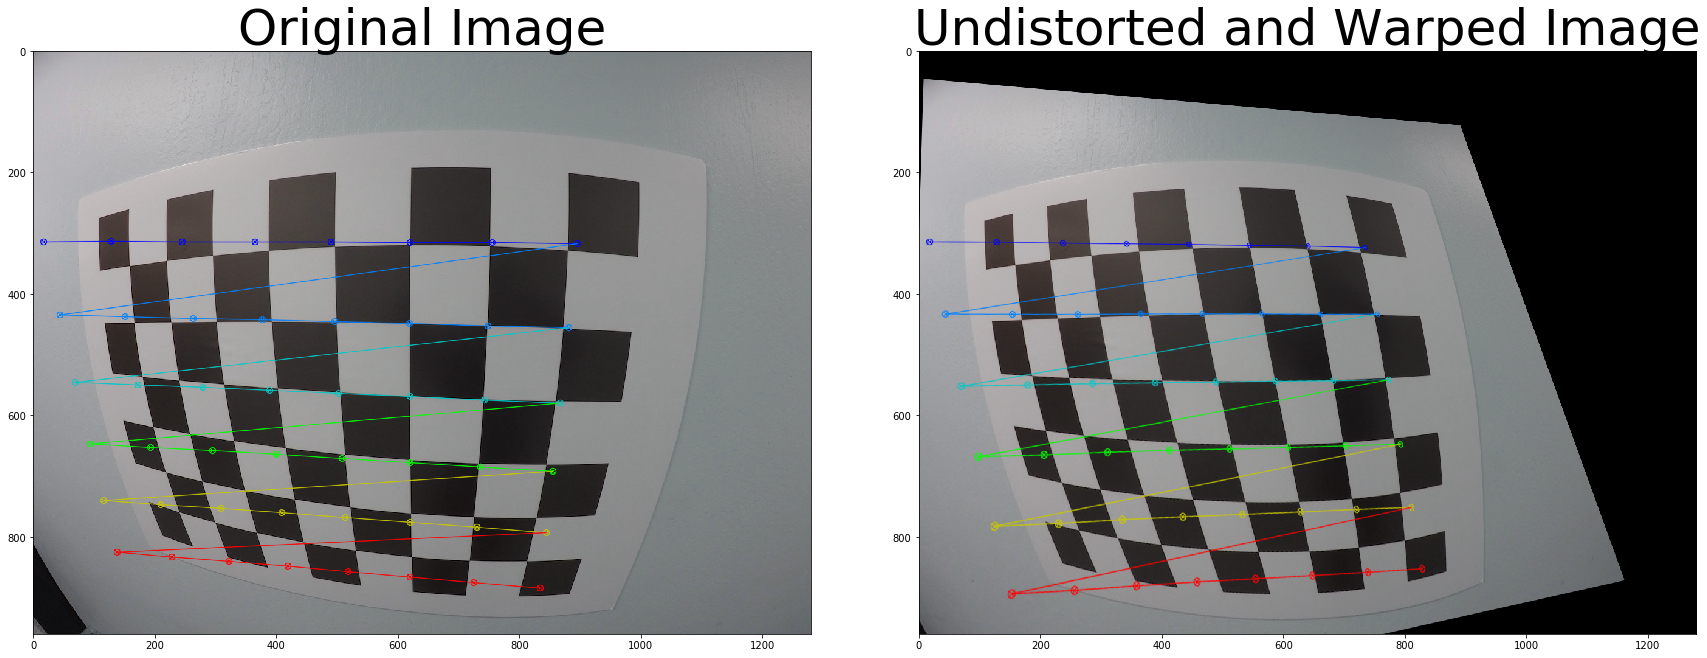

In [101]:
nx = 8 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(dst,cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
    # 4) If corners found: 
            # a) draw corners
    img = cv2.drawChessboardCorners(img, (8,6), corners, ret)
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
    src[0] = corners[0]
    src[1] = corners[1]
    src[2] = corners[8]
    src[3] = corners[9]
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32(
        [[17, 315],
         [127, 315],
         [43, 434],
         [153, 434]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
            
    #delete the next two lines
    #M = None
    #warped = np.copy(img) 
    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)